In [13]:
import pandas as pd
import numpy as np
from numba.experimental.jitclass.base import imp_dtor

# read the kick dataset
df = pd.read_csv('data/kick.csv')
# show all columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41432 non-null  object 
 7   Transmission                       41432 non-null  object 
 8   WheelTypeID                        41432 non-null  object 
 9   WheelType                          41380 non-null  object 
 10  VehOdo                             41432 non-null  float64
 11  Nationality                        41432 non-null  obj

/var/folders/47/bp92rfhd2px7jptsh2w9nw1m0000gp/T/ipykernel_19562/4072060898.py:6: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/kick.csv')


In [14]:
# STEP 1 : Investigation
# Get descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values represented as "?"
missing_values = (df == '?').sum()
print("\nMissing Values Represented as '?':")
print(missing_values[missing_values > 0])

# Check for any other unusual values
print("\nUnique values in categorical columns:")
categorical_cols = ['Auction', 'Make', 'Color', 'Transmission', 'WheelType',
                    'Nationality', 'Size',
                    'TopThreeAmericanName',
                    'PRIMEUNIT', 'AUCGUART', 'VNST', 'ForSale', 'IsOnlineSale', 'IsBadBuy', 'VehYear']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}: {df[col].unique()}")


Descriptive Statistics:
         PurchaseID  PurchaseTimestamp       VehYear         VehOdo  \
count  41476.000000       4.147600e+04  41432.000000   41432.000000   
mean   20737.500000       1.262260e+09   2005.360615   71300.010427   
std    11973.234219       1.796895e+07      1.730587   14724.041171   
min        0.000000       1.231114e+09   2001.000000     577.000000   
25%    10368.750000       1.247530e+09   2004.000000   61578.000000   
50%    20737.500000       1.262045e+09   2005.000000   73128.500000   
75%    31106.250000       1.277770e+09   2007.000000   82259.250000   
max    41475.000000       1.293667e+09   2010.000000  480444.000000   

       WarrantyCost      IsBadBuy  
count  41432.000000  41476.000000  
mean    1273.050758      0.129497  
std      599.188662      0.335753  
min      462.000000      0.000000  
25%      834.000000      0.000000  
50%     1155.000000      0.000000  
75%     1623.000000      0.000000  
max     7498.000000      1.000000  

Missing Va

In [15]:
# STEP 2: Handle Missing Value

df.replace(['?', 'nan', 'NaN', 'NAN', 'NOT AVAIL', 'Not Avail', 'not avail'], np.nan, inplace=True)
# Correcting Data Type
cols_numerical = [
    'MMRAcquisitionAuctionAveragePrice',
    'MMRAcquisitionAuctionCleanPrice',
    'MMRAcquisitionRetailAveragePrice',
    'MMRAcquisitonRetailCleanPrice',
    'MMRCurrentAuctionAveragePrice',
    'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice',
    'MMRCurrentRetailCleanPrice',
    'MMRCurrentRetailRatio',
    'VehBCost',
]

for col in cols_numerical:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert PurchaseDate to datetime
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'], format='%d/%m/%Y %H:%M')
df['PurchaseYear'] = df['PurchaseDate'].dt.year
df['PurchaseMonth'] = df['PurchaseDate'].dt.month
df.drop(columns=['PurchaseDate'], inplace=True)
df['WheelTypeID'] = df['WheelTypeID'].astype(str)
df['WheelType'] = df['WheelType'].astype(str)
df['VNST'] = df['VNST'].astype(str)
df['PRIMEUNIT'] = df['PRIMEUNIT'].astype(str).str.upper().str.strip()
df['AUCGUART'] = df['AUCGUART'].astype(str).str.upper().str.strip()
primeunit_map = {'YES': 1, 'NO': 0}
df['PRIMEUNIT'] = df['PRIMEUNIT'].map(primeunit_map)
aucguart_map = {'GREEN': 1, 'RED': 0}
df['AUCGUART'] = df['AUCGUART'].map(aucguart_map)

df['ForSale'] = df['ForSale'].astype(str).str.upper().str.strip()
forsale_map = {'YES': 1, 'NO': 0}
df['ForSale'] = df['ForSale'].map(forsale_map).astype('Int64')

isonlinesale_map = {
    '0': 0, '0.0': 0, 0: 0, 0.0: 0,
    '1': 1, '1.0': 1, 1: 1, 1.0: 1
}

# Incorrect:
df['IsOnlineSale'] = df['IsOnlineSale'].astype(str).str.strip()
df['IsOnlineSale'] = df['IsOnlineSale'].map(isonlinesale_map)
# Convert to pandas nullable integer type
df['IsOnlineSale'] = df['IsOnlineSale'].astype('Int64')


# Correcting Invalid Values
mask = df['VehOdo'] <= 0
df.loc[mask, 'VehOdo'] = np.nan

mask = df['VehBCost'] <= 0
df.loc[mask, 'VehBCost'] = np.nan

mask = df['WarrantyCost'] < 0
df.loc[mask, 'WarrantyCost'] = np.nan

mask = df['MMRCurrentRetailRatio'] < 0
df.loc[mask, 'MMRCurrentRetailRatio'] = np.nan

mask = df['MMRAcquisitionAuctionAveragePrice'] <= 0
df.loc[mask, 'MMRAcquisitionAuctionAveragePrice'] = np.nan

mask = df['MMRAcquisitionAuctionCleanPrice'] <= 0
df.loc[mask, 'MMRAcquisitionAuctionCleanPrice'] = np.nan

mask = df['MMRAcquisitionRetailAveragePrice'] <= 0
df.loc[mask, 'MMRAcquisitionRetailAveragePrice'] = np.nan

mask = df['MMRAcquisitonRetailCleanPrice'] <= 0
df.loc[mask, 'MMRAcquisitonRetailCleanPrice'] = np.nan

mask = df['MMRCurrentAuctionAveragePrice'] <= 0
df.loc[mask, 'MMRCurrentAuctionAveragePrice'] = np.nan

mask = df['MMRCurrentAuctionCleanPrice'] <= 0
df.loc[mask, 'MMRCurrentAuctionCleanPrice'] = np.nan

mask = df['MMRCurrentRetailAveragePrice'] <= 0
df.loc[mask, 'MMRCurrentRetailAveragePrice'] = np.nan

mask = df['MMRCurrentRetailCleanPrice'] <= 0
df.loc[mask, 'MMRCurrentRetailCleanPrice'] = np.nan

df['VehYear'] = df['VehYear'].astype(str)
df['WheelTypeID'] = df['WheelTypeID'].astype(str)

# Replace "?" with NaN for easier handling
df.replace(['?', 'NOT AVAIL', 'Not Avail', 'not avail', 'N/A', 'n/a', 'nan', '<NA>'], np.nan, inplace=True)

# Check missing values again
print("\nMissing Values After Replacement:")
print(df.isnull().sum())



Missing Values After Replacement:
PurchaseID                               0
PurchaseTimestamp                        0
Auction                                 44
VehYear                                 44
Make                                    44
Color                                  115
Transmission                            50
WheelTypeID                           1819
WheelType                             1873
VehOdo                                  44
Nationality                             47
Size                                    47
TopThreeAmericanName                    47
MMRAcquisitionAuctionAveragePrice      569
MMRAcquisitionAuctionCleanPrice        469
MMRAcquisitionRetailAveragePrice       556
MMRAcquisitonRetailCleanPrice          657
MMRCurrentAuctionAveragePrice          518
MMRCurrentAuctionCleanPrice            437
MMRCurrentRetailAveragePrice           538
MMRCurrentRetailCleanPrice             538
MMRCurrentRetailRatio                  538
PRIMEUNIT          

In [16]:
# STEP 3: Drop PRIMEUNIT/AUCGUART since > 50% of data is missing & Drop redundant field
# Drop PRIMEUNIT/AUCGUART since > 50% of data is missing
missing_ratio = df.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Drop Unnecessary
df.drop(['PurchaseID','WheelTypeID'], axis=1, inplace=True)

# Get descriptive statistics
print("\nDescriptive Statistics:")
print(df.info())



Descriptive Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseTimestamp                  41476 non-null  int64  
 1   Auction                            41432 non-null  object 
 2   VehYear                            41432 non-null  object 
 3   Make                               41432 non-null  object 
 4   Color                              41361 non-null  object 
 5   Transmission                       41426 non-null  object 
 6   WheelType                          39603 non-null  object 
 7   VehOdo                             41432 non-null  float64
 8   Nationality                        41429 non-null  object 
 9   Size                               41429 non-null  object 
 10  TopThreeAmericanName               41429 non-null  object 
 11  MMRAcquisitionAuctionAverageP

In [17]:
# STEP4: Data Imputation (Numerical value => MEAN , Categorical value => Mode)
# Exclude ID, Timestamp, Year
imp_numeric_cols = [#'PurchaseID',
                    # 'PurchaseTimestamp',
                    # 'WheelTypeID',
                    'VehOdo',
                'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
                'MMRCurrentRetailRatio', 'VehBCost',
                'WarrantyCost']

for col in imp_numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# For numeric columns, impute missing values with median
for col in imp_numeric_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        # print(f"Imputed missing values in {col} with median: {median_val}")

# For categorical columns, impute with mode
for col in categorical_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        # print(f"Imputed missing values in {col} with mode: {mode_val}")

# Check missing values again
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
PurchaseTimestamp                    0
Auction                              0
VehYear                              0
Make                                 0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
MMRCurrentRetailRatio                0
VNST                                 0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
ForSale                       

/var/folders/47/bp92rfhd2px7jptsh2w9nw1m0000gp/T/ipykernel_19562/2445443689.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/var/folders/47/bp92rfhd2px7jptsh2w9nw1m0000gp/T/ipykernel_19562/2445443689.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseTimestamp                  41476 non-null  int64  
 1   Auction                            41476 non-null  object 
 2   VehYear                            41476 non-null  object 
 3   Make                               41476 non-null  object 
 4   Color                              41476 non-null  object 
 5   Transmission                       41476 non-null  object 
 6   WheelType                          41476 non-null  object 
 7   VehOdo                             41476 non-null  float64
 8   Nationality                        41476 non-null  object 
 9   Size                               41476 non-null  object 
 10  TopThreeAmericanName               41476 non-null  object 
 11  MMRAcquisitionAuctionAveragePrice  41476 non-null  flo

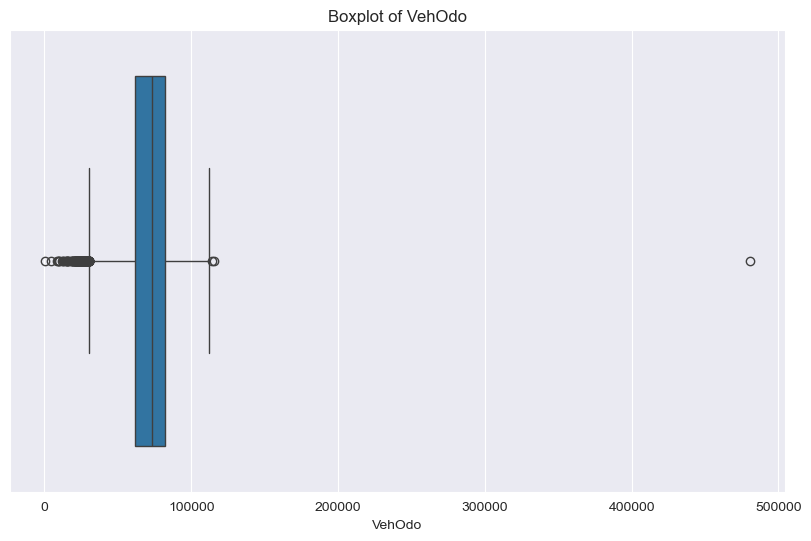

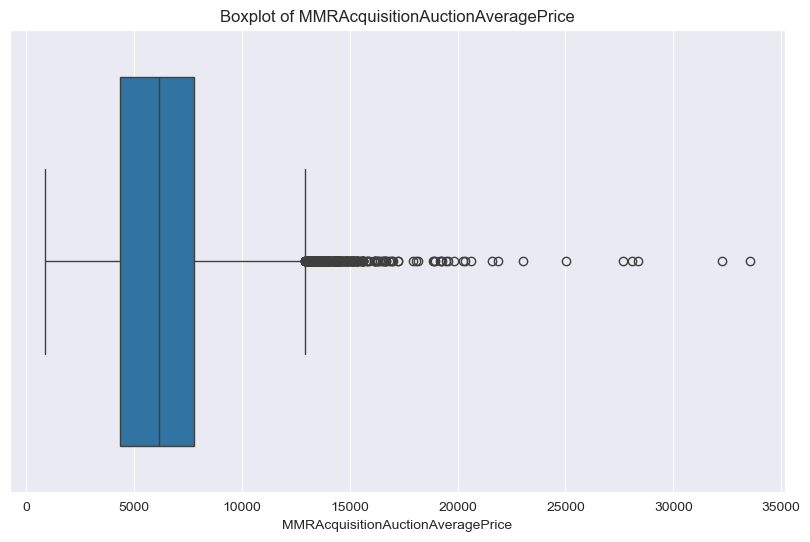

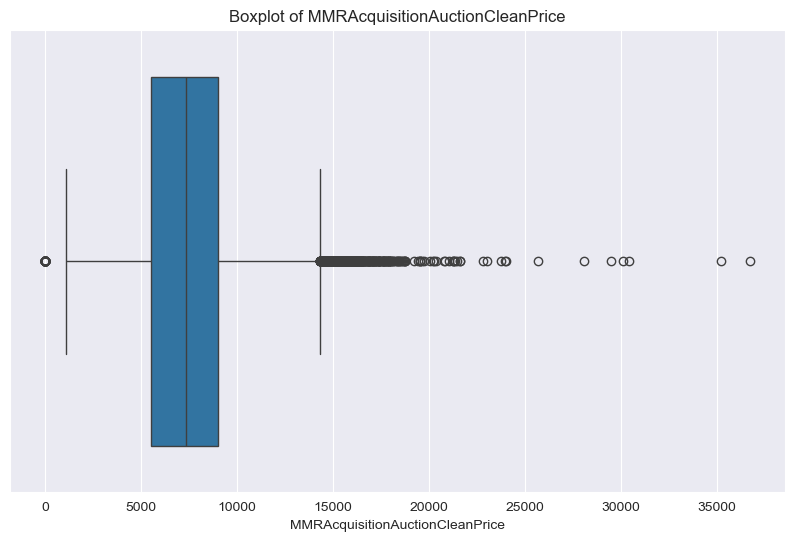

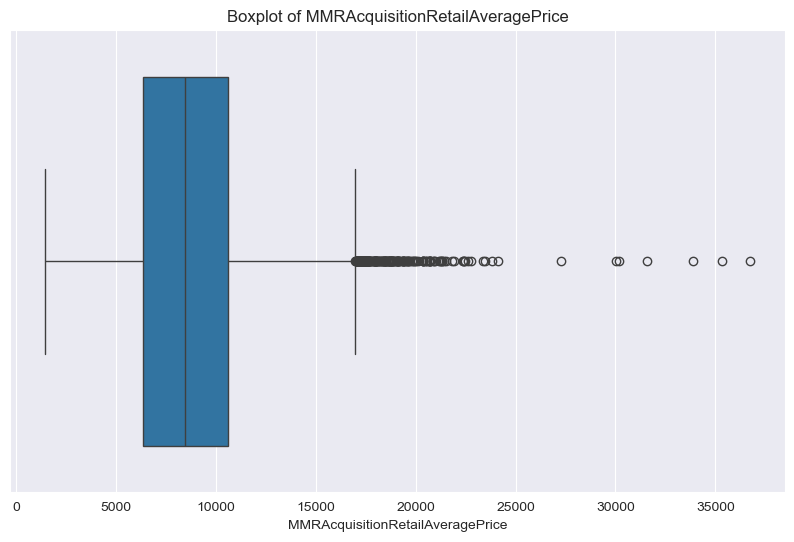

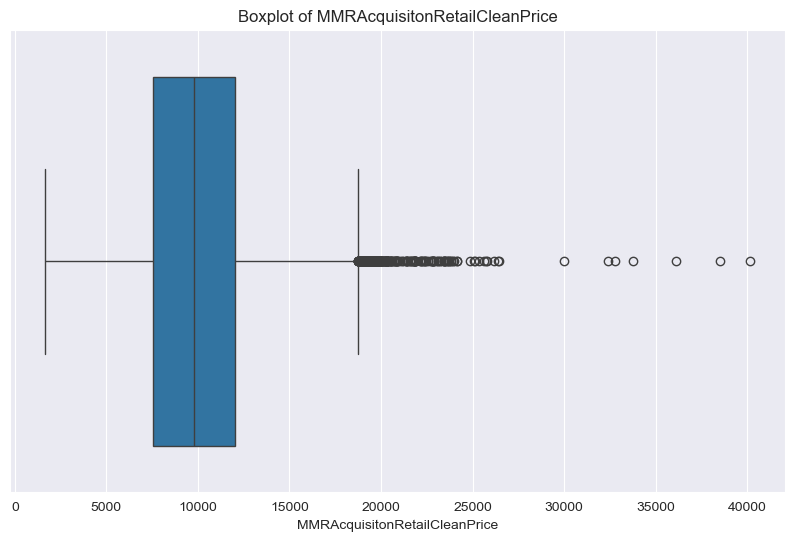

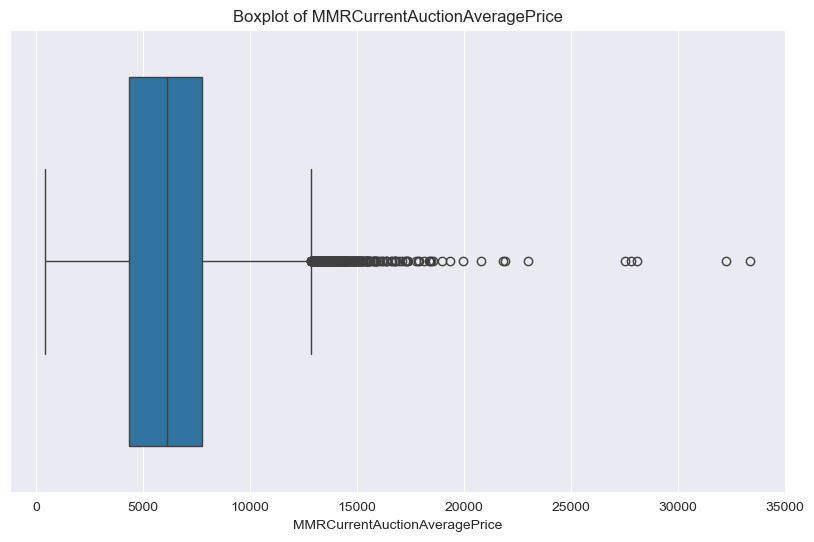

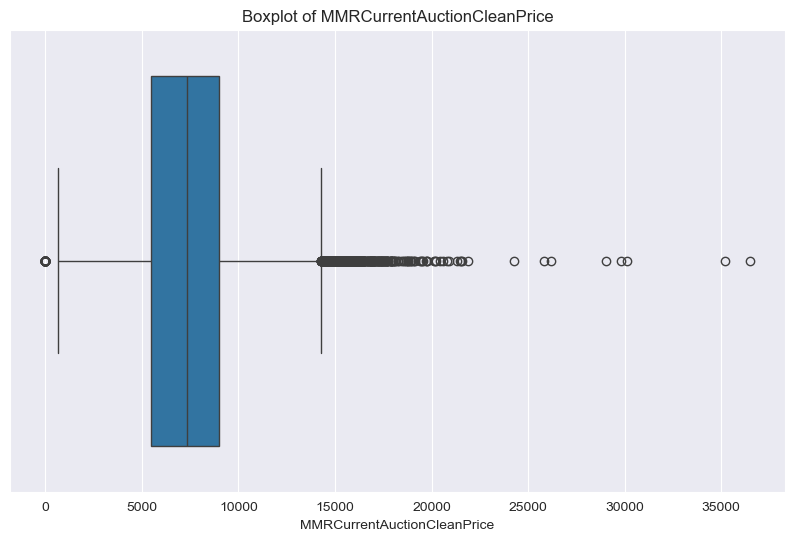

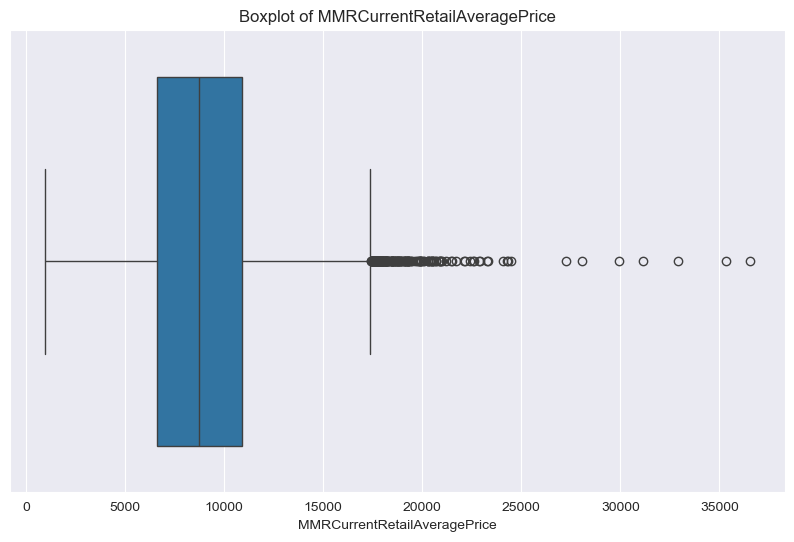

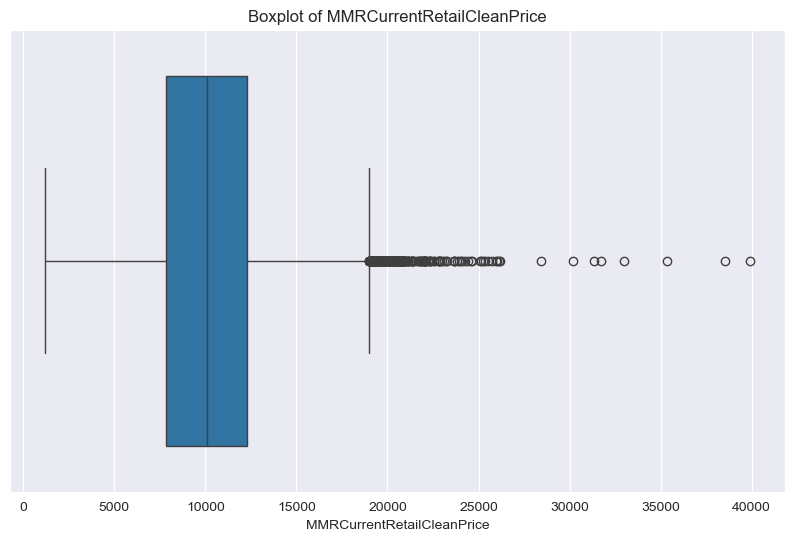

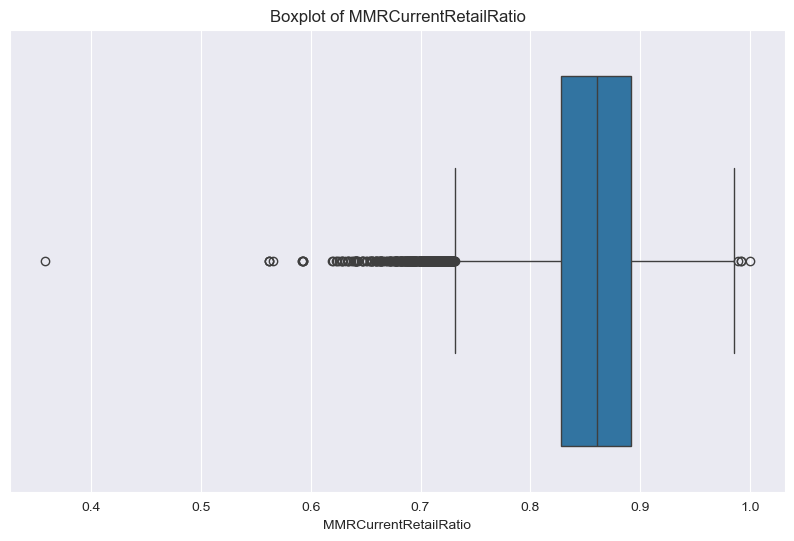

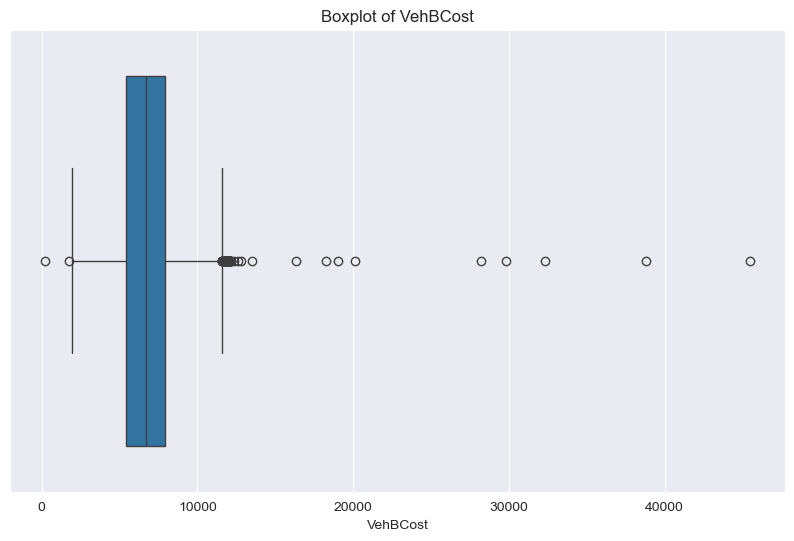

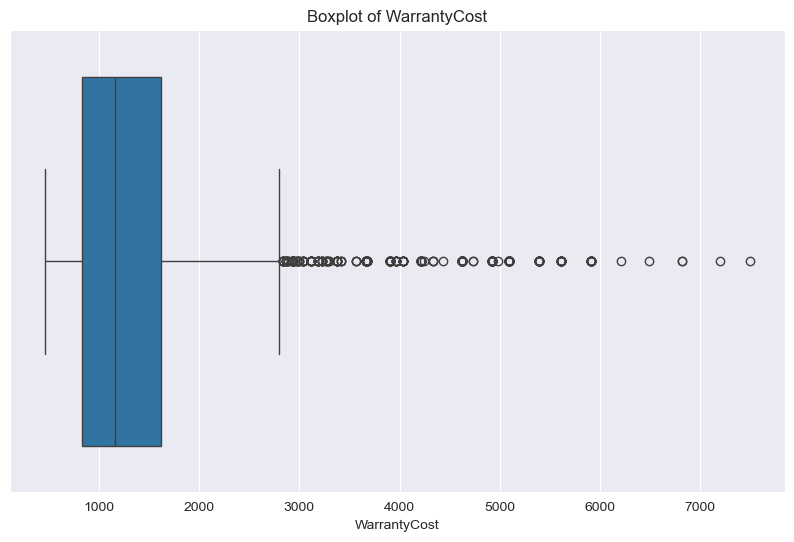

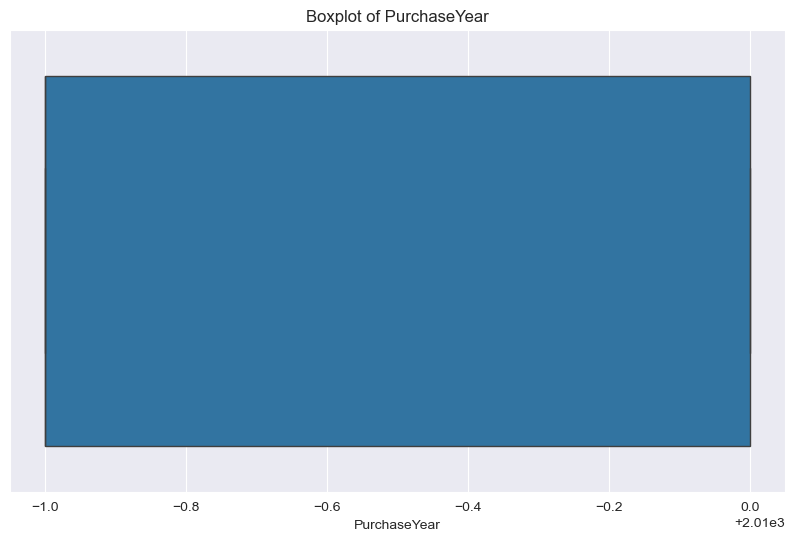

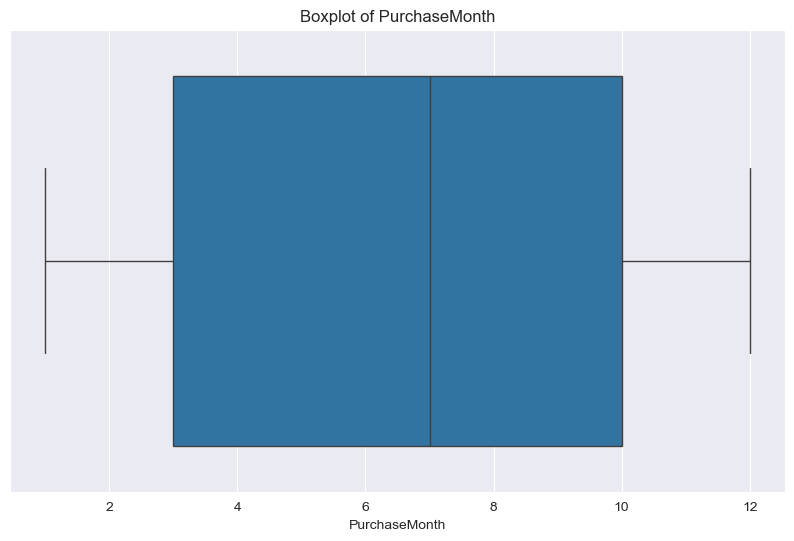

VehOdo: 187 outliers detected
MMRAcquisitionAuctionAveragePrice: 330 outliers detected
MMRAcquisitionAuctionCleanPrice: 625 outliers detected
MMRAcquisitionRetailAveragePrice: 216 outliers detected
MMRAcquisitonRetailCleanPrice: 299 outliers detected
MMRCurrentAuctionAveragePrice: 357 outliers detected
MMRCurrentAuctionCleanPrice: 607 outliers detected
MMRCurrentRetailAveragePrice: 186 outliers detected
MMRCurrentRetailCleanPrice: 258 outliers detected
MMRCurrentRetailRatio: 637 outliers detected
VehBCost: 113 outliers detected
WarrantyCost: 470 outliers detected
PurchaseYear: 0 outliers detected
PurchaseMonth: 0 outliers detected


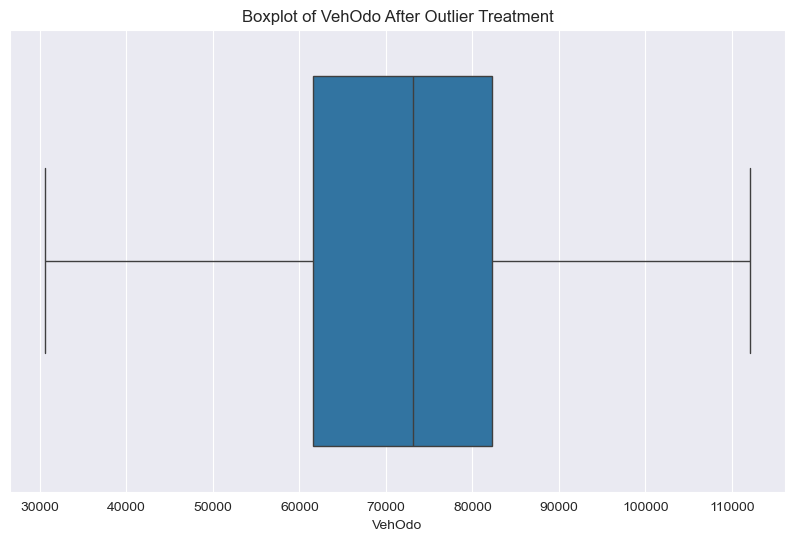

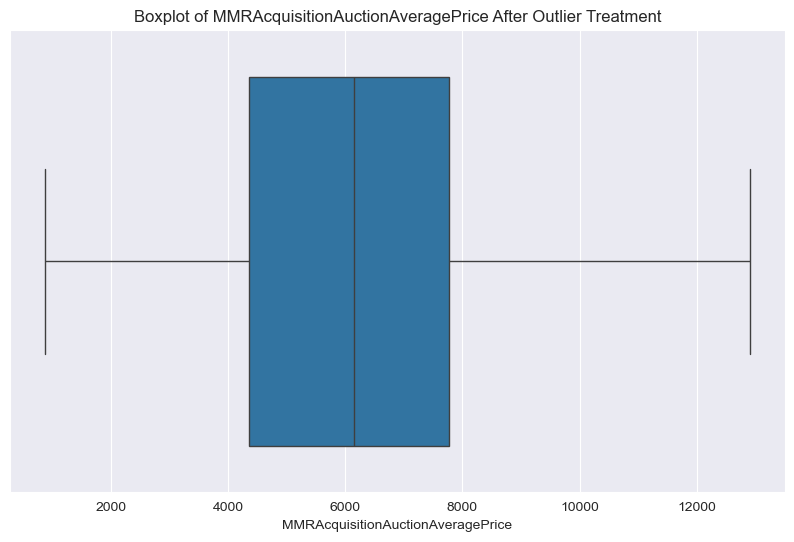

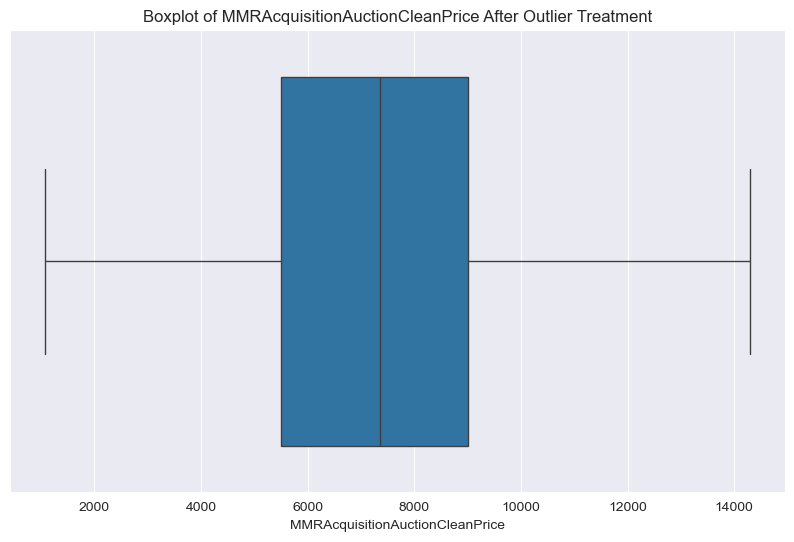

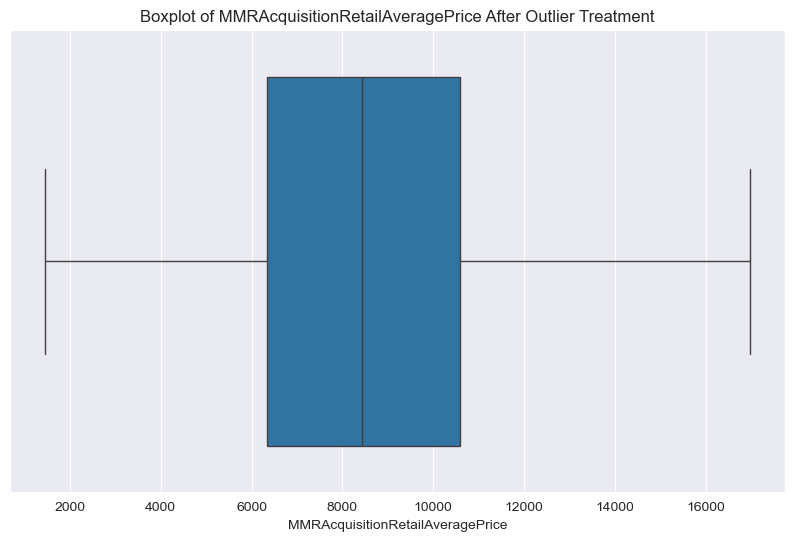

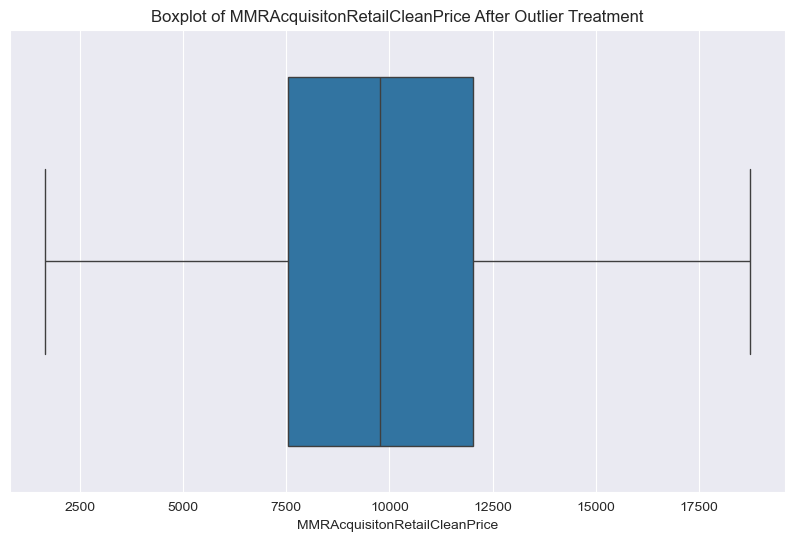

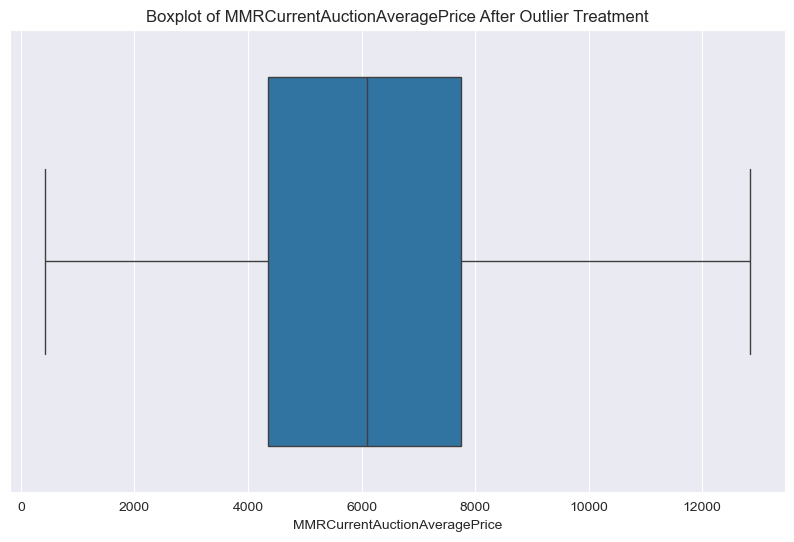

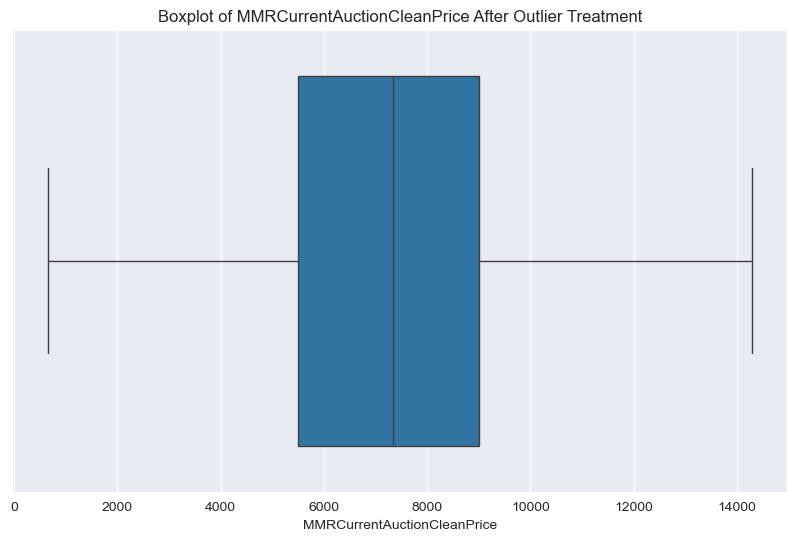

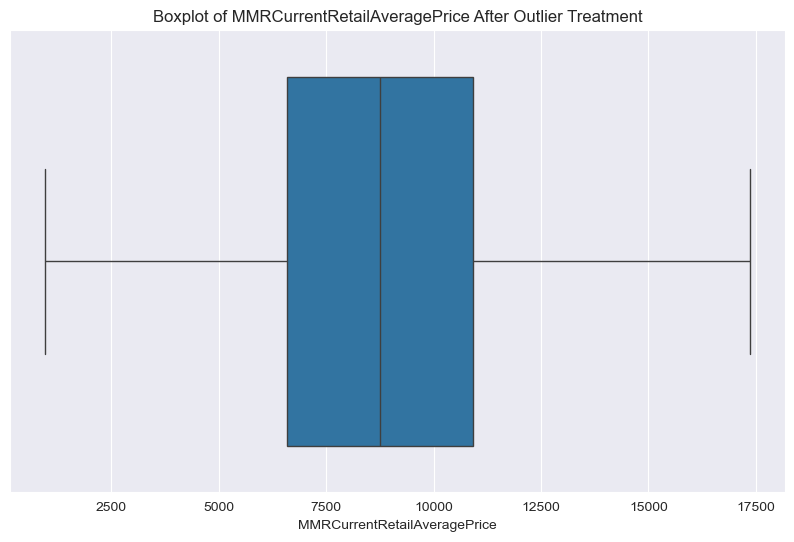

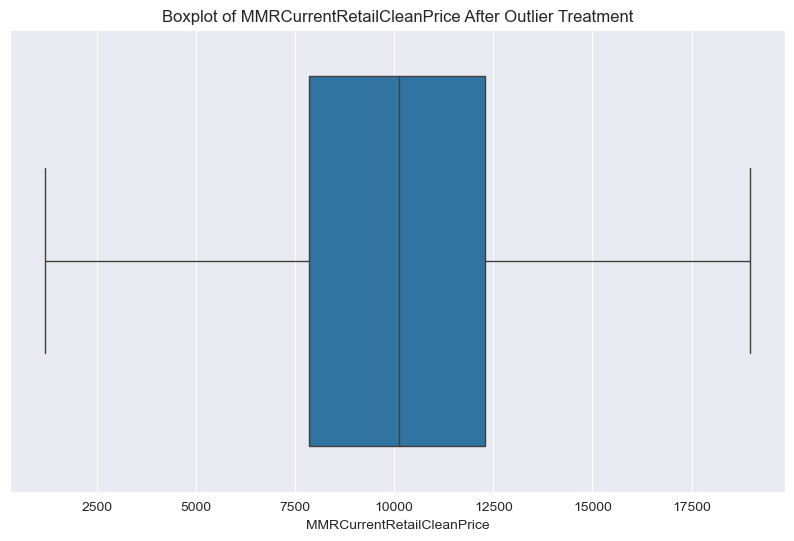

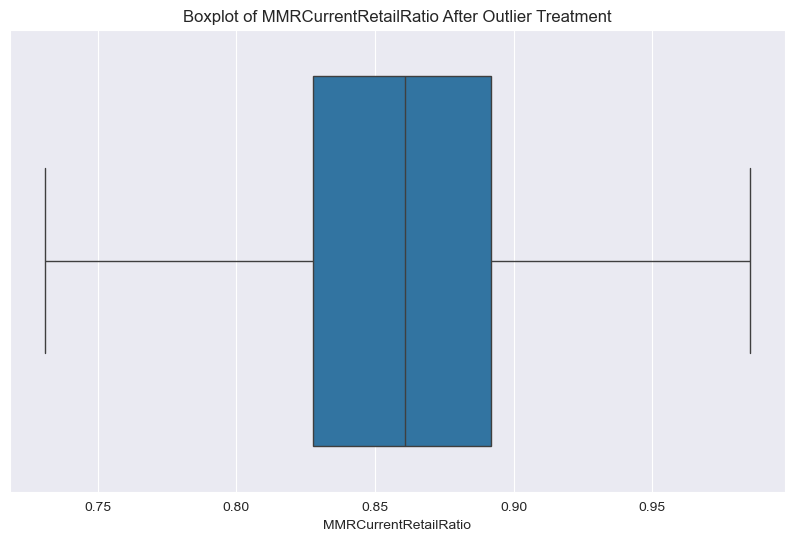

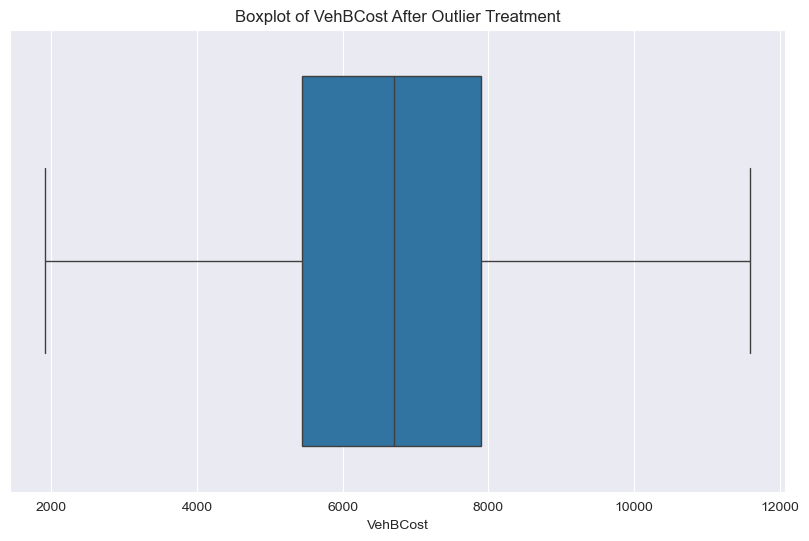

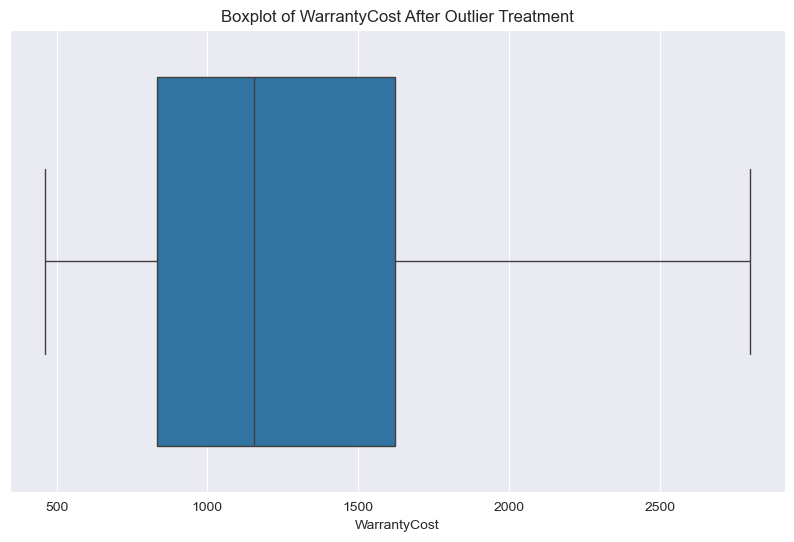

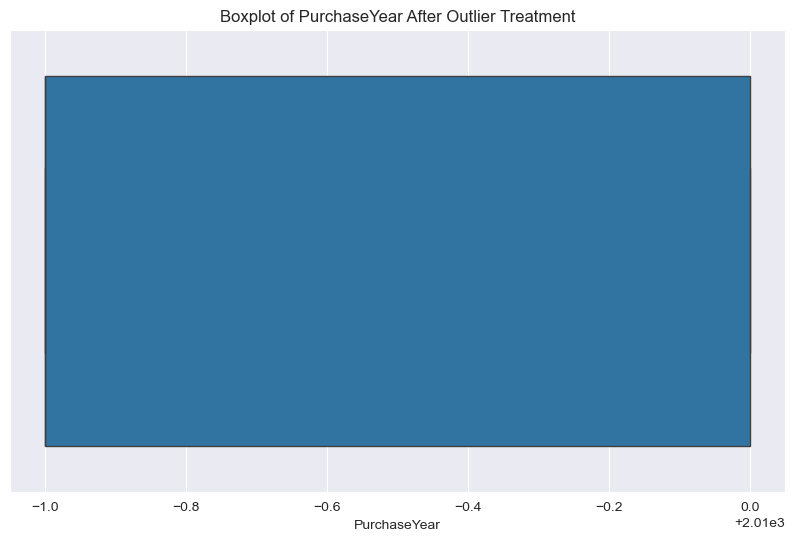

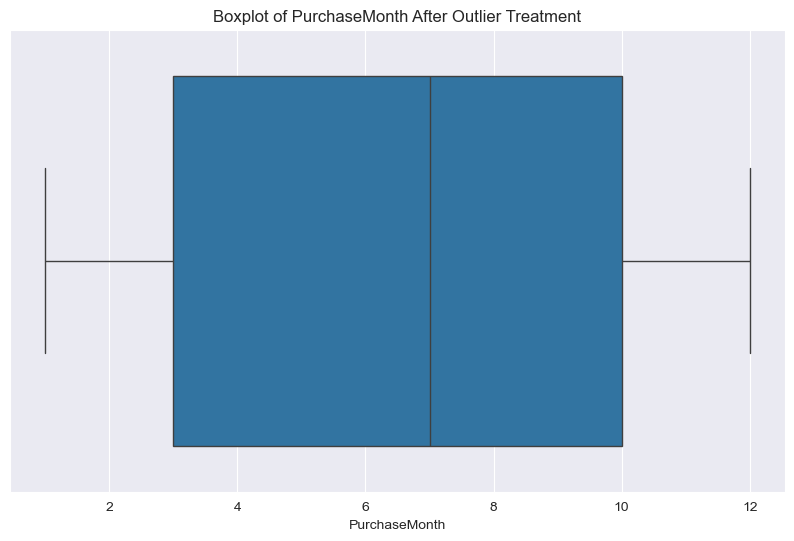

In [19]:
# STEP5: Outlier fixing
from matplotlib import pyplot as plt
import seaborn as sns

# Visualize numeric columns to identify outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    if col not in ['PurchaseID', 'PurchaseTimestamp', 'IsBadBuy', 'IsOnlineSale',
                   'ForSale']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Function to handle outliers using IQR method
def handle_outliers(df, col, method='median'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers detected")

    if method == 'median':
        df.loc[df[col] < lower_bound, col] = Q1
        df.loc[df[col] > upper_bound, col] = Q3
    elif method == 'remove':
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

# Handle outliers for each numeric column
for col in numeric_cols:
    if col not in ['PurchaseID', 'PurchaseTimestamp', 'IsBadBuy', 'IsOnlineSale',
                   'ForSale']:
        df = handle_outliers(df, col, method='median')

# Visualize the data after handling outliers
for col in numeric_cols:
    if col not in ['PurchaseID', 'PurchaseTimestamp', 'IsBadBuy', 'IsOnlineSale',
                   'ForSale']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} After Outlier Treatment')
        plt.show()

In [20]:
#STEP6: Remove Duplicate

# Check for duplicate records
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

# If duplicates exist, remove them
if duplicate_rows > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_rows} duplicate rows")
    print(f"New dataset shape: {df.shape}")
else:
    print("No duplicate rows found")


Number of duplicate rows: 40
Removed 40 duplicate rows
New dataset shape: (41436, 28)


In [22]:
#STEP7: Final review and save
# Final review of the cleaned dataset
print("\nFinal Dataset Info:")
print(df.info())

print("\nFinal Dataset Head:")
print(df.head())

print("\nFinal Dataset Descriptive Statistics:")
print(df.describe())

# Check for any remaining missing values
print("\nRemaining Missing Values:")
print(df.isnull().sum())

from datetime import datetime
# Get the current datetime object
current_datetime = datetime.now()
# Format the datetime object into a string (YYYY-MM-DD HH:MM:SS)
date_time_string = current_datetime.strftime("%Y%m%d")

# Save the cleaned dataset
filename = f'{date_time_string}_cleaned_kick.csv'
df.to_csv(filename, index=False)
print("\nCleaned dataset saved to " + filename)


Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 41436 entries, 0 to 41475
Columns: 124 entries, PurchaseTimestamp to VNST_WV
dtypes: Int64(2), bool(106), float64(12), int32(2), int64(2)
memory usage: 10.0 MB
None

Final Dataset Head:
   PurchaseTimestamp   VehOdo  MMRAcquisitionAuctionAveragePrice  \
0         1253232000  51099.0                             8566.0   
1         1253232000  48542.0                             8566.0   
2         1253232000  46318.0                             8835.0   
3         1253232000  50413.0                             7165.0   
4         1253232000  50199.0                             8566.0   

   MMRAcquisitionAuctionCleanPrice  MMRAcquisitionRetailAveragePrice  \
0                           9325.0                            9751.0   
1                           9325.0                            9751.0   
2                           9428.0                           10042.0   
3                           7770.0                 

Categorical columns in the dataset:
['Auction', 'VehYear', 'Make', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'VNST']
Auction: 3 unique values
VehYear: 10 unique values
Make: 30 unique values
Color: 15 unique values
Transmission: 3 unique values
WheelType: 3 unique values
Nationality: 5 unique values
Size: 12 unique values
TopThreeAmericanName: 4 unique values
VNST: 31 unique values


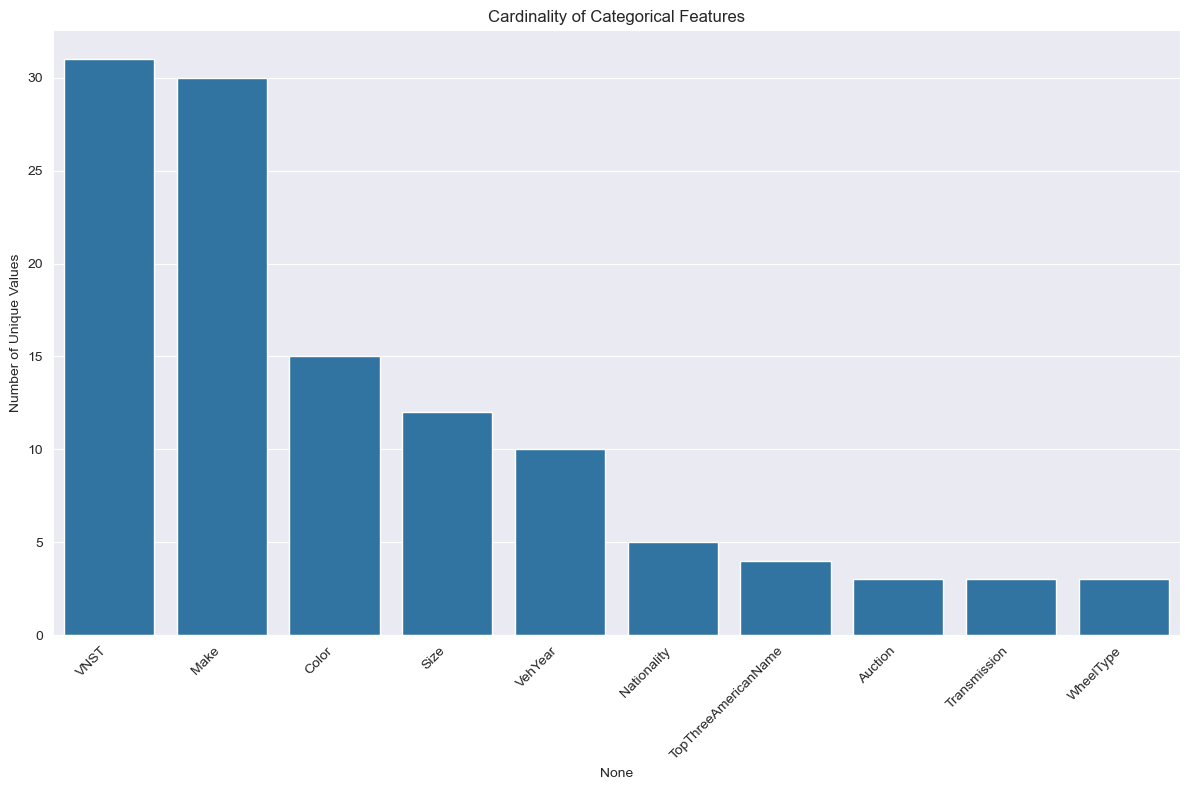


Low cardinality features (≤15 unique values) - Suitable for one-hot encoding:
['Auction', 'VehYear', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName']

Medium cardinality features (16-50 unique values) - Consider alternative encoding:
['Make', 'VNST']

High cardinality features (>50 unique values) - Avoid one-hot encoding:
[]


In [21]:
# STEP8: Fix One-hot encoding

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns in the dataset:")
print(categorical_cols)

# Calculate cardinality for each categorical column
cardinality = {}
for col in categorical_cols:
    unique_count = df[col].nunique()
    cardinality[col] = unique_count
    print(f"{col}: {unique_count} unique values")

# Convert to DataFrame for better visualization
cardinality_df = pd.DataFrame.from_dict(cardinality, orient='index', columns=['Cardinality'])
cardinality_df = cardinality_df.sort_values(by='Cardinality', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot cardinality
plt.figure(figsize=(12, 8))
sns.barplot(x=cardinality_df.index, y='Cardinality', data=cardinality_df)
plt.xticks(rotation=45, ha='right')
plt.title('Cardinality of Categorical Features')
plt.ylabel('Number of Unique Values')
plt.tight_layout()
plt.show()

# Set thresholds
low_cardinality_threshold = 15  # Features with ≤15 unique values
high_cardinality_threshold = 50  # Features with >50 unique values

# Classify features based on cardinality
low_cardinality_cols = []
medium_cardinality_cols = []
high_cardinality_cols = []

for col, count in cardinality.items():
    if count <= low_cardinality_threshold:
        low_cardinality_cols.append(col)
    elif count <= high_cardinality_threshold:
        medium_cardinality_cols.append(col)
    else:
        high_cardinality_cols.append(col)

print(f"\nLow cardinality features (≤{low_cardinality_threshold} unique values) - Suitable for one-hot encoding:")
print(low_cardinality_cols)

print(f"\nMedium cardinality features ({low_cardinality_threshold+1}-{high_cardinality_threshold} unique values) - Consider alternative encoding:")
print(medium_cardinality_cols)

print(f"\nHigh cardinality features (>{high_cardinality_threshold} unique values) - Avoid one-hot encoding:")
print(high_cardinality_cols)

df = pd.get_dummies(df, columns=low_cardinality_cols+medium_cardinality_cols, drop_first=True)



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41436 entries, 0 to 41475
Columns: 123 entries, PurchaseTimestamp to VNST_WV
dtypes: Int64(2), bool(106), datetime64[ns](1), float64(12), int64(2)
memory usage: 10.0 MB


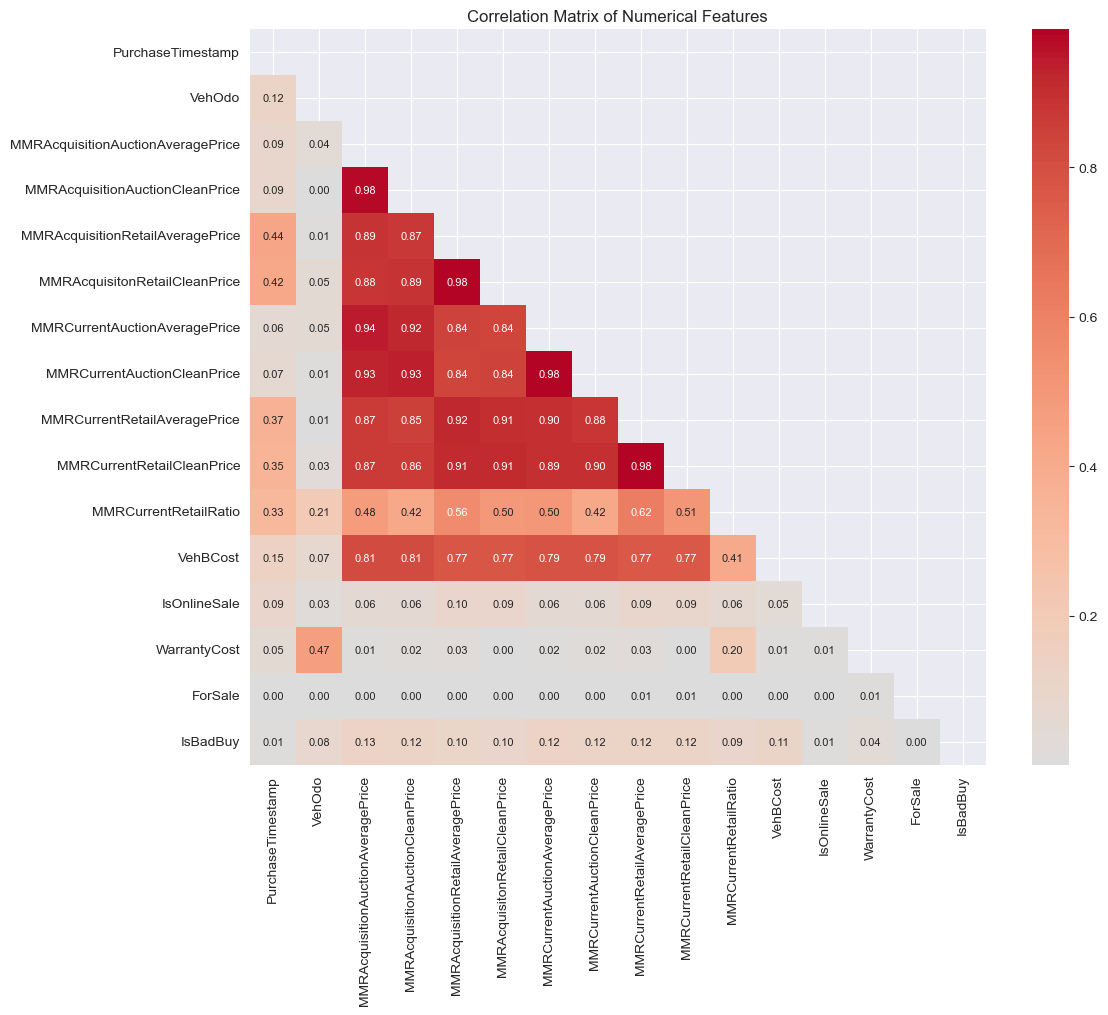

Features with correlation > 0.8: ['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost']

Dataset shape after removing correlated features: (41436, 115)


In [12]:
# STEP9: Check Correlation mask

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical features for correlation analysis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_numerical = df[numerical_cols]

# Calculate the correlation matrix
correlation_matrix = df_numerical.corr().abs()
correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
    annot_kws={'size': 8}, cmap='coolwarm', center=0,
    mask=correlation_mask, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


# Create a mask for the upper triangle
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Apply the mask to the correlation matrix
upper_corr = correlation_matrix.where(upper_triangle)

# Find features with correlation greater than a threshold (e.g., 0.8)
threshold = 0.8
high_corr_features = [column for column in upper_corr.columns if any(upper_corr[column] > threshold)]

print(f"Features with correlation > {threshold}: {high_corr_features}")

# Drop highly correlated features
df_final = df.drop(columns=high_corr_features)

print("\nDataset shape after removing correlated features:", df_final.shape)
